# Histopathologic Cancer Detection with a Convolutional Neural Network

The goal of this project is to create a CNN model capable of predicting the presence of cancer in image patches taken from larger digital pathology scans. For a given image, a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

The dataset for this project consists of 220,025 training images and 57,458 testing images, located in independent "train" and "test" folders. All images have a (96,96) size (9,216 pixels per image) and are stored in the Tag Image File Format (TIFF). These images will be converted to PNG format to be able to import them into the Keras library.

A list of labels for the training dataset is stored as a CSV file outside of either directory, and it consists of two colums:
* <b>id</b> - This is a unique identifier that corresponds to a given image's filename.
* <b>label</b> - A binary value that indicates if image center contains a tumor. 

In [2]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from keras import layers

## Exploratory Data Analysis

First, we begin by observing what is the distribution of class samples within the training dataset.

In [3]:
training_labels = pd.read_csv('./Data/train_labels.csv')
training_labels = training_labels.sort_values('id', ascending=True)

counts = training_labels["label"].value_counts()
indexes = [index for index, _ in counts.items()]
percentages = [ round(value / sum(counts), 5)*100 for _, value in counts.items() ]

data_distibution = pd.DataFrame({"Amount": counts.to_list(), "Percentage": percentages}, index=indexes)
data_distibution

,Amount,Percentage
0,130908,59.497
1,89117,40.503


We can observe that the training dataset has a roughly even split between both classes. While there are more "false" samples the skew is not so large as to require a dataset re-balancing during model creation and training. Furthermore, the large amount of samples within each group will compensate for the imperfect split.

Below we can better visualize the trainiing dataset distribution with a histogram.

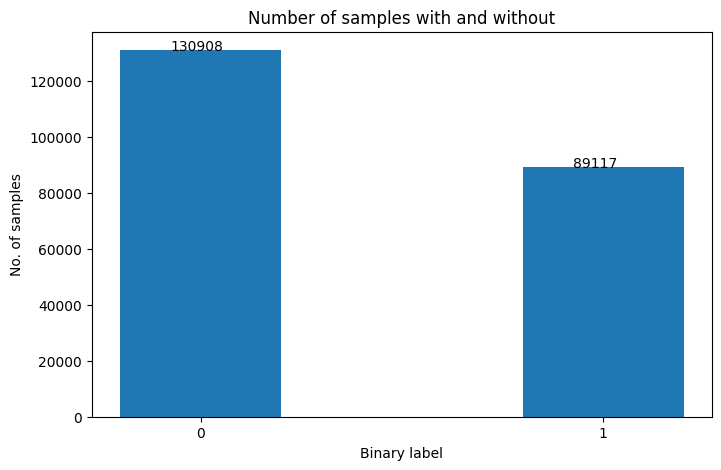

In [4]:
# creating the dataset
data = counts
topics = list(data.axes[0])
topics = [str(item) for item in topics]
values = list(data.values)
  
fig = plt.figure(figsize = (8, 5))
plt.bar(topics, values, width = 0.4)

for i in range(len(values)):
        plt.text( i-0.075, values[i]+2, values[i])

plt.xlabel("Binary label")
plt.ylabel("No. of samples")
plt.title("Number of samples with and without")
plt.show()

To obtain a better idea of how the samples are composed, we can randomly open an image and observe its composition. The most important values to confirm are the image size (width, height) as well as its depth and whether the image is monochromatic, RGB, CMYK or some other format.

width:  96
height: 96


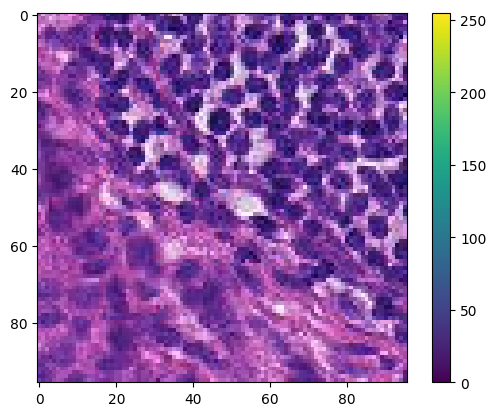

In [5]:
im = Image.open('./Data/train/000a2a35668f04edebc0b06d5d133ad90c93a044.tif')
w, h = im.size
print('width: ', w)
print('height:', h)

plt.imshow(im)
plt.colorbar()


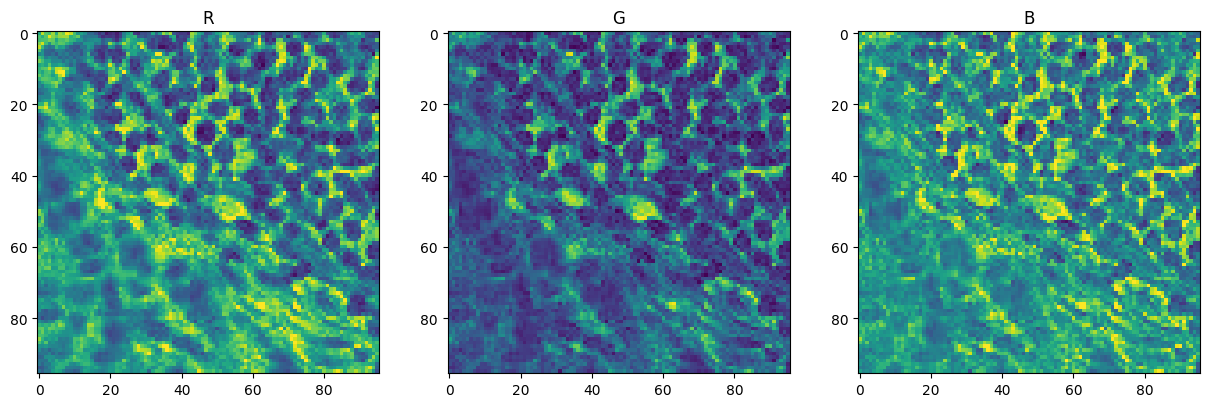

In [6]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))
band_values = []

for i in range(len(bands)):
    band_values.append(im.getchannel(bands[i]))
    axarr[i].imshow(band_values[i])
    axarr[i].title.set_text(bands[i])

As we can see in the plots above, the images are coded in the RGB format, for a resulting depth of 3 on input arrays. Furthermore, the data contained in each channel within is different from one another, cofirming the images are truly RGB and not a monochromatic image copied three times.

To get a better idea of how color dispersion, we can plot a histogram for the pixel values across each channel.

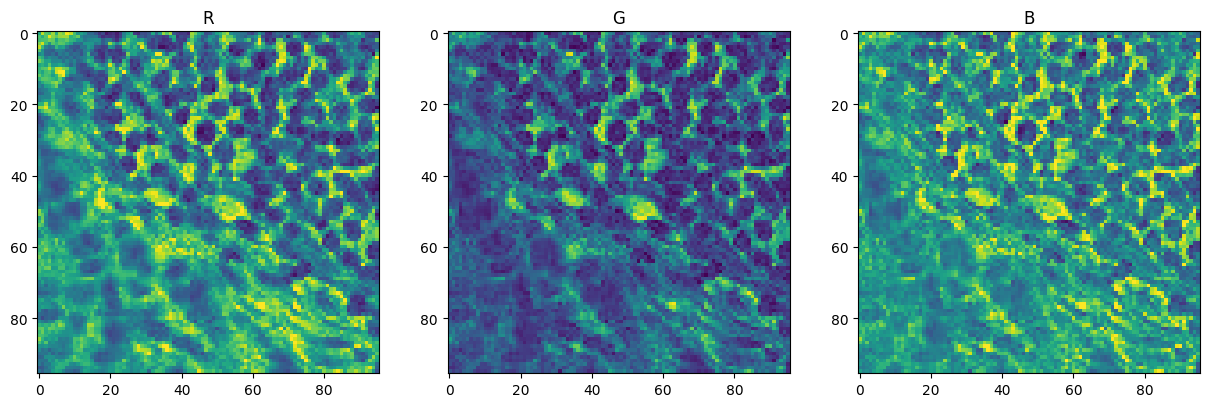

In [7]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))
band_values = []

for i in range(len(bands)):
    band_values.append(im.getchannel(bands[i]))
    axarr[i].imshow(band_values[i])
    axarr[i].title.set_text(bands[i])


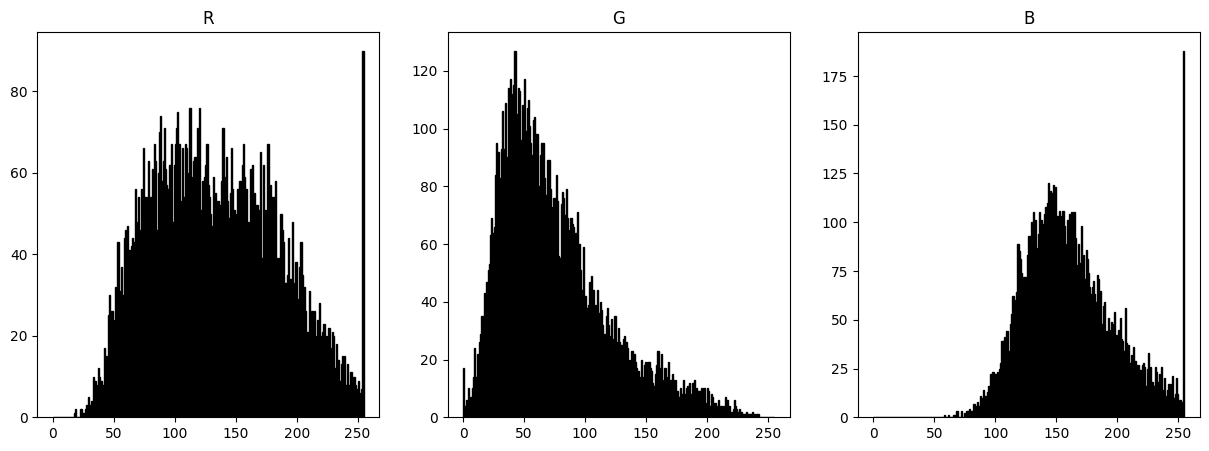

In [8]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))

for i in range(len(band_values)):
    axarr[i].title.set_text(bands[i])
    axarr[i].hist(np.ravel(band_values[i]), bins=range(256), fc='k', ec='k')

The Red and Blue channels appear to be normally distributed, while the Green channel has a right-skewed distribution.

For further analysis, we will repeat the previous process with another random image and observe the histrogram results. 

width:  96
height: 96


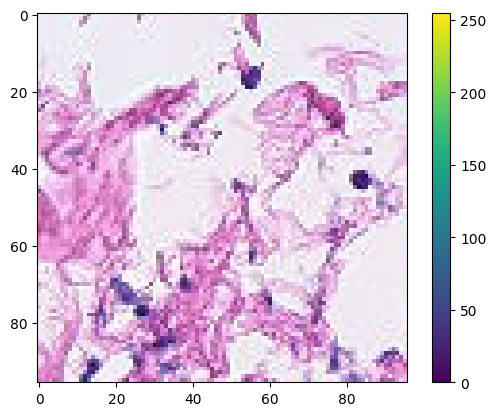

In [9]:
im = Image.open('./Data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
w, h = im.size
print('width: ', w)
print('height:', h)

plt.imshow(im)
plt.colorbar()


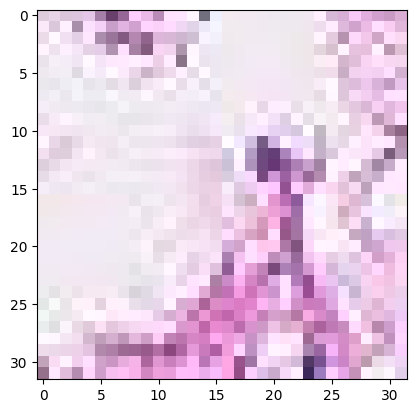

In [10]:
im = Image.open('./Data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
im2 = im.crop((32, 32, 64, 64))
plt.imshow(im2)

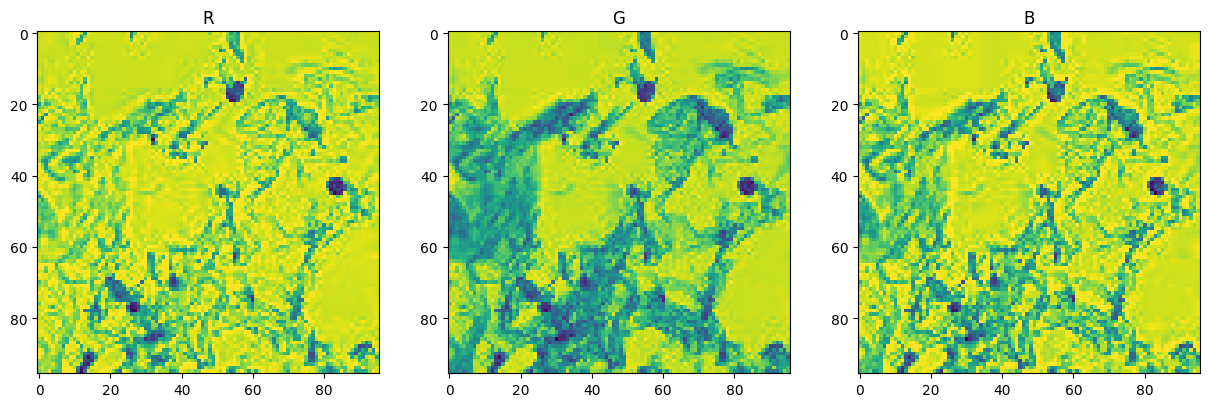

In [11]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))
band_values = []

for i in range(len(bands)):
    band_values.append(im.getchannel(bands[i]))
    axarr[i].imshow(band_values[i])
    axarr[i].title.set_text(bands[i])


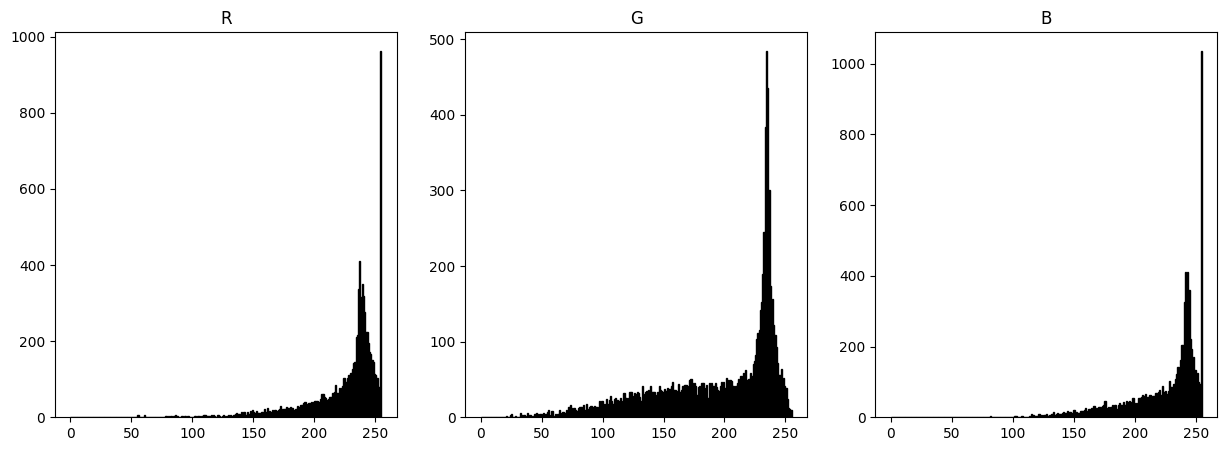

In [12]:
# bands = im.getbands
bands = im.getbands()

f, axarr = plt.subplots(1,len(bands), figsize = (15, 5))

for i in range(len(band_values)):
    axarr[i].title.set_text(bands[i])
    axarr[i].hist(np.ravel(band_values[i]), bins=range(256), fc='k', ec='k')

On this image, all three channels are heavily left-skewed in their pixel values. This is a very different light distribution when compared to the previous image.

From this we can conclude there are two possible pre-processing paths to take:
* We could leave all images as they are and submit them to the CNN without any pre-processing
* We could apply dynamic range techniques to each image before submitting it to the model. This would normalize the inputs to the model, but some information may be lost.

For this project, the only processing to be done to the images will be a channel rescaling, to convert the 0-255 values to a 0-1 scale.

## Dataset Construction

The datasets for training and testing this model will be created using the Keras image_dataset_from_directory() function. This function requires that training samples be separated by classes into different folders.

Therefore, the first step will be to take all images in the train folder and separate them between according to their label.

In [15]:
training_directory = "./Data/train_png/"

# For all files in training directory
for filename in os.listdir(training_directory):
    if os.path.isfile(filename):
        # Split filename and extension extension
        id = filename[:len(filename)-4]
        ext = filename[len(filename)-4:]

        # Get image's index within training_labels
        index = training_labels.index[training_labels['id'] == id].tolist()[0]

        # Get correspongind image's label
        label = training_labels.loc[index]["label"]

        # Obtain folder path
        folder_path = training_directory + str(label) + "/"
        
        # If it does not exist, create the class folder
        if not os.path.exists(folder_path): 
            os.makedirs(folder_path) 

        # Move file to corresponding folder
        os.rename(  training_directory + str(id) + ext, 
                    folder_path + str(id) + ext)

Once the samples have been separated, we can import them into a Keras dataset item. As this is a binary prediction problem, the label mode will be set to "binary". Also, 20% of the samples will be taken out from training dataset to be used for the model's validation.

In [17]:
training_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    training_directory,
    labels="inferred",
    label_mode="binary",
    image_size=(96, 96),
    shuffle=True,
    validation_split=0.2,
    subset="both",
    seed=17
)

training_dataset

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Using 44005 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

To ensure that samples were properly split and validation dataset contains both True and False elements, we can calculate the average of labels across each dataset, and ensure it is a value similar to the true proportion obtained during Data Exploration. 

In [18]:
training_labels = [label[0] for _, label in training_dataset]
validation_labels = [label[0] for _, label in validation_dataset]

print(sum(training_labels) / len(training_dataset))
print(sum(validation_labels) / len(validation_dataset))

tf.Tensor([0.40538085], shape=(1,), dtype=float32)
tf.Tensor([0.3815407], shape=(1,), dtype=float32)


As we can see, both datasets have an average around 40%, which means the proportion between samples has been properly kept. Finally, we can import the testing dataset and then procede to creating the CNN model.

In [33]:
testing_dataset = keras.utils.image_dataset_from_directory(
    './Data/test_png/',
    labels=None,
    label_mode=None,
    image_size=(96, 96),
    shuffle=False,
)

testing_dataset

Found 57458 files belonging to 1 classes.


<BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>

As the image_dataset_from_directory() function stores the samples according to os.walk(), we can use that function to get a list of the appropriate IDs in the same order as the dataset.

In [34]:
for root, dirs, files in os.walk("./Data/test_png/", topdown=False):
    testing_ids = [name[:len(name)-4] for name in files]
print(len(testing_ids))

57458


## Model Architecture

Given that the problem is based on only the center 32x32 pixels, each sample will be croped to analyze the center zone.

Then, the images will be passed through convolusion blocks. This block will apply two convolutions with ReLU activation and a Batch Normalization to the image. Afterwards, it will pool the filters using a Max() function. There will be four convolution blocks, with 16, 32, 64 and 128 filters each respectively. After every two blocks, a Dropout layer will be used to mitigate overfitting. 

Once the image has passed through all convolutions, the result will be flattened and then submitted to a three-layer dense network with ReLU activations, with 512, 128 and 32 neurons per layer. Similar to the convolutions, after each dense layer the result will be normalized with Batch Normalization and then a dropout layer will be used to prevent overfitting.

The final output will be inputted into a Sigmoid Perceptron to obtain the final classification probability.



In [25]:
def conv_block(filters, inputs, kernel_size = 3):
    x = layers.SeparableConv2D(filters, kernel_size, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, kernel_size, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    return x


def dense_block(units, inputs, dropout_rate = 0.1):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    return x

In [47]:
def build_model():
    
    inputs = keras.Input(shape=(96, 96, 3))
    x = layers.Cropping2D(32)(inputs)

    x = conv_block(16, x)
    x = conv_block(32, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(64, x)
    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = dense_block(512, x, 0.5)
    x = dense_block(128, x, 0.3)
    x = dense_block(32, x, 0.2)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define model's architecture
model = build_model()

# Print model's architecture
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 cropping2d_4 (Cropping2D)   (None, 32, 32, 3)         0         
                                                                 
 separable_conv2d_62 (Separa  (None, 32, 32, 16)       91        
 bleConv2D)                                                      
                                                                 
 separable_conv2d_63 (Separa  (None, 32, 32, 16)       416       
 bleConv2D)                                                      
                                                                 
 batch_normalization_45 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                           

#### Model Training

For training the model a maximum of 30 epochs will be used, with an early stopping optimizer with a patience of 3 epochs.

The model's loss will be calculated using Binary Cross-Entropy. The metrics for Accuracy, Precision and Recall will also be calculated to evaluate the learning rate after training is complete

In [30]:
epochs = 30

# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")],
)

# Train model
history = model.fit(
    training_dataset,
    epochs=epochs,
    validation_data= validation_dataset,
    callbacks=[early_stopping_cb]
) 


Epoch 1/30
5501/5501 [==============================] - 83s 15ms/step - loss: 0.5269 - binary_accuracy: 0.7510 - precision: 0.7213 - recall: 0.6277 - val_loss: 0.5471 - val_binary_accuracy: 0.7538 - val_precision: 0.6577 - val_recall: 0.8176
Epoch 2/30
5501/5501 [==============================] - 80s 15ms/step - loss: 0.4807 - binary_accuracy: 0.7808 - precision: 0.7703 - recall: 0.6538 - val_loss: 0.4774 - val_binary_accuracy: 0.7859 - val_precision: 0.7336 - val_recall: 0.7401
Epoch 3/30
5501/5501 [==============================] - 83s 15ms/step - loss: 0.4692 - binary_accuracy: 0.7871 - precision: 0.7735 - recall: 0.6707 - val_loss: 0.4804 - val_binary_accuracy: 0.7842 - val_precision: 0.7085 - val_recall: 0.7934
Epoch 4/30
5501/5501 [==============================] - 79s 14ms/step - loss: 0.4617 - binary_accuracy: 0.7910 - precision: 0.7764 - recall: 0.6797 - val_loss: 0.4865 - val_binary_accuracy: 0.7822 - val_precision: 0.6952 - val_recall: 0.8233
Epoch 5/30
5501/5501 [==========

#### Model Results

To evaluate the model's training efficiency we can plot the evaluation metrics across time for each epoch.

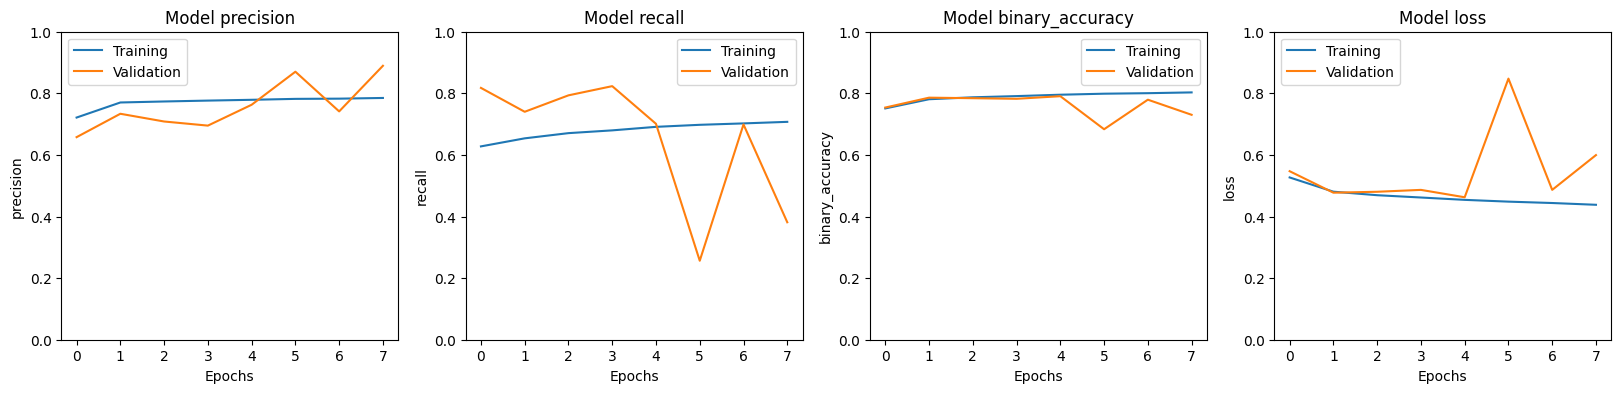

In [31]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(20, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


We can observe that the model

Finally, we can make a prediction onto the testing dataset and export it into a CSV file for submittion onto Kaggle. 

In [35]:
# Obtain predicted labels for testing dataset
testing_predictions = model.predict(testing_dataset)
testing_prediction_labels = [item[0] for item in testing_predictions.tolist()]

# Merge testing ids and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "label": testing_prediction_labels})
testing_results.to_csv("./Data/results.csv", index=False)
testing_results.head()

1796/1796 [==============================] - 12s 7ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.480459
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.906390
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.172855
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.788517
4,000270442cc15af719583a8172c87cd2bd9c7746,0.035996


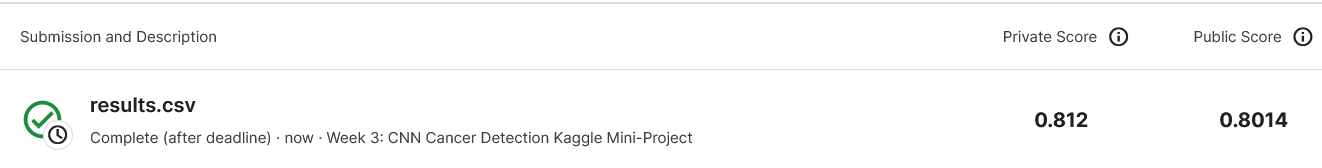

We can see that this initial architecture had good results, with an 80% score on the Testing Dataset. We can now try and improve this score by training CNN models with different parameters.

## Alternative Models

### Alternative Model Architecture

Firstly, we will observe the results of adding more convolusional layers to the network. For this, we will remove the cropping operation and process the full 96x96 images. Furthermore, we will add an additional 1024-neurons dense layer after convolution.

In [46]:
def build_model():
    
    inputs = keras.Input(shape=(96, 96, 3))

    x = conv_block(16, inputs)
    x = conv_block(32, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(64, x)
    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)
    
    x = conv_block(256, x)
    x = conv_block(512, x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)

    x = dense_block(1024, x, 0.5)
    x = dense_block(512, x, 0.5)
    x = dense_block(128, x, 0.3)
    x = dense_block(32, x, 0.2)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define model's architecture
model = build_model()

# Print model's architecture
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 separable_conv2d_50 (Separa  (None, 96, 96, 16)       91        
 bleConv2D)                                                      
                                                                 
 separable_conv2d_51 (Separa  (None, 96, 96, 16)       416       
 bleConv2D)                                                      
                                                                 
 batch_normalization_35 (Bat  (None, 96, 96, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 48, 48, 16)       0         
 g2D)                                                      

In [41]:
epochs = 30

# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")],
)

# Train model
history = model.fit(
    training_dataset,
    epochs=epochs,
    validation_data= validation_dataset,
    callbacks=[early_stopping_cb]
) 


Epoch 1/30
5501/5501 [==============================] - 194s 35ms/step - loss: 0.7011 - binary_accuracy: 0.5751 - precision: 0.4117 - recall: 0.1143 - val_loss: 0.6740 - val_binary_accuracy: 0.5950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
5501/5501 [==============================] - 191s 35ms/step - loss: 0.5594 - binary_accuracy: 0.6989 - precision: 0.7037 - recall: 0.4431 - val_loss: 0.5187 - val_binary_accuracy: 0.7111 - val_precision: 0.8816 - val_recall: 0.3310
Epoch 3/30
5501/5501 [==============================] - 185s 34ms/step - loss: 0.4062 - binary_accuracy: 0.8227 - precision: 0.8064 - recall: 0.7399 - val_loss: 0.5540 - val_binary_accuracy: 0.7469 - val_precision: 0.9064 - val_recall: 0.4183
Epoch 4/30
5501/5501 [==============================] - 193s 35ms/step - loss: 0.3620 - binary_accuracy: 0.8441 - precision: 0.8238 - recall: 0.7824 - val_loss: 0.4908 - val_binary_accuracy: 0.8052 - val_precision: 0.7608 - val_recall: 0.7571
Epoch 5/30
5501/5501

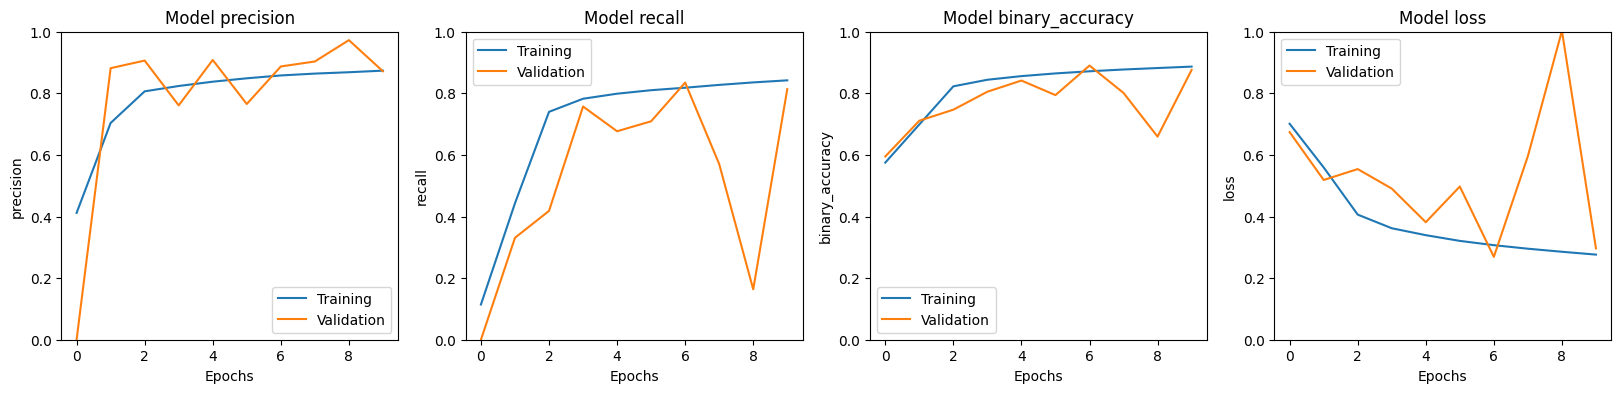

In [44]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(20, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


As we can see in the previous graphs, this new model's accuracy and precision quickly approached 100% with both the training and validation datasets. While Recall and Loss had big deviations from the trend on epoch 8, the Early Stop callback was capable of detecting it and returning the model to its best iteration.

Now, we procede to generate the predictions for the new model and compare the results agains the original model.

In [45]:
# Obtain predicted labels for testing dataset
testing_predictions = model.predict(testing_dataset)
testing_prediction_labels = [item[0] for item in testing_predictions.tolist()]

# Merge testing ids and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "label": testing_prediction_labels})
testing_results.to_csv("./Data/results_model_2.csv", index=False)
testing_results.head()

   1/1796 [..............................] - ETA: 45s

1796/1796 [==============================] - 18s 10ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.954676
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.865297
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.318610
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.320590
4,000270442cc15af719583a8172c87cd2bd9c7746,0.007264


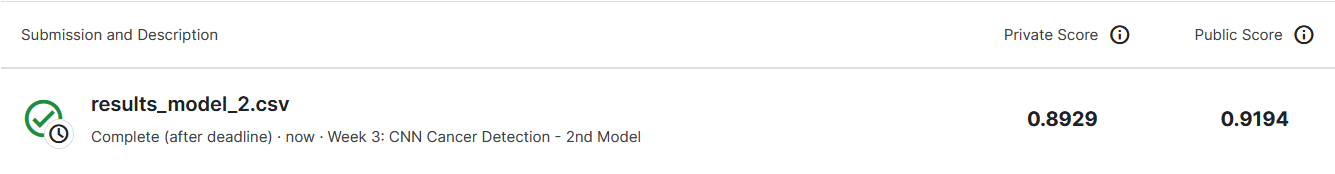

The new model was capable of a 12% increase in the testing score, crossing the 90%. However, this is in great part due to new model having more than four times the number of parameters. It is possible that the previous model architecture could be optimized to obtain a smaller model that could still acheive a similar result.

### Hyperparameter tuning

Instead of doubling the filters from one convolutional layer to the next, we could try to increase them by a constant amount. Likewise, we could try to adjust the number of neurons in each dense feed-forward layer to reduce the model's size.

Furthermore, the dropout rate has also been increased for the convolutional layers and the first dense layer.

In [48]:
def build_model():
    
    inputs = keras.Input(shape=(96, 96, 3))
    x = layers.Cropping2D(32)(inputs)

    x = conv_block(16, x)
    x = conv_block(32, x)
    x = layers.Dropout(0.3)(x)

    x = conv_block(48, x)
    x = conv_block(64, x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    x = dense_block(192, x, 0.7)
    x = dense_block(128, x, 0.3)
    x = dense_block(64, x, 0.2)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define model's architecture
model = build_model()

# Print model's architecture
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 cropping2d_5 (Cropping2D)   (None, 32, 32, 3)         0         
                                                                 
 separable_conv2d_70 (Separa  (None, 32, 32, 16)       91        
 bleConv2D)                                                      
                                                                 
 separable_conv2d_71 (Separa  (None, 32, 32, 16)       416       
 bleConv2D)                                                      
                                                                 
 batch_normalization_52 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                           

This adjusted model has the same number and order of layers as the first one, but has less than a third of the parameters. 

Now we will procede to training and evaluation to measure how well this model does.

In [52]:
epochs = 30

# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.005),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")],
)

# Train model
history = model.fit(
    training_dataset,
    epochs=epochs,
    validation_data= validation_dataset,
    callbacks=[early_stopping_cb]
) 


Epoch 1/30


5501/5501 [==============================] - 84s 15ms/step - loss: 0.4807 - binary_accuracy: 0.7823 - precision: 0.7736 - recall: 0.6540 - val_loss: 0.6333 - val_binary_accuracy: 0.6592 - val_precision: 0.5601 - val_recall: 0.7383
Epoch 2/30
5501/5501 [==============================] - 82s 15ms/step - loss: 0.4690 - binary_accuracy: 0.7892 - precision: 0.7766 - recall: 0.6733 - val_loss: 0.4608 - val_binary_accuracy: 0.8044 - val_precision: 0.7583 - val_recall: 0.7589
Epoch 3/30
5501/5501 [==============================] - 82s 15ms/step - loss: 0.4595 - binary_accuracy: 0.7938 - precision: 0.7759 - recall: 0.6904 - val_loss: 0.4458 - val_binary_accuracy: 0.8052 - val_precision: 0.8097 - val_recall: 0.6785
Epoch 4/30
5501/5501 [==============================] - 82s 15ms/step - loss: 0.4537 - binary_accuracy: 0.7957 - precision: 0.7756 - recall: 0.6972 - val_loss: 0.4699 - val_binary_accuracy: 0.7835 - val_precision: 0.8540 - val_recall: 0.5613
Epoch 5/30
5501/5501 [=====================

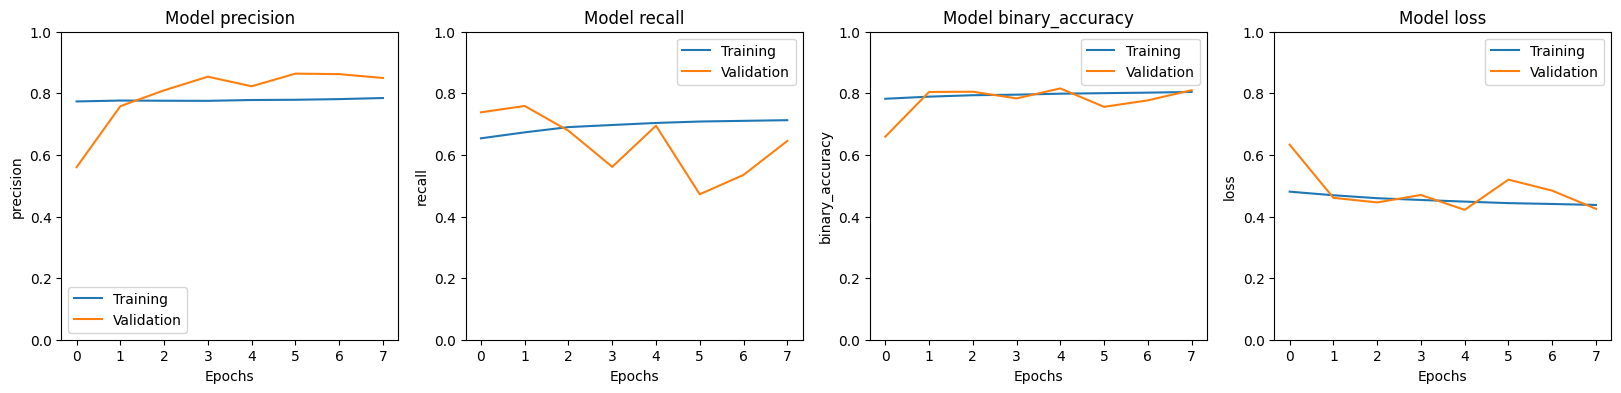

In [55]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(20, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


In [54]:
# Obtain predicted labels for testing dataset
testing_predictions = model.predict(testing_dataset)
testing_prediction_labels = [item[0] for item in testing_predictions.tolist()]

# Merge testing ids and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "label": testing_prediction_labels})
testing_results.to_csv("./Data/results_model_3.csv", index=False)
testing_results.head()

1796/1796 [==============================] - 12s 6ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.457601
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.828963
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.355644
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.162269
4,000270442cc15af719583a8172c87cd2bd9c7746,0.084894


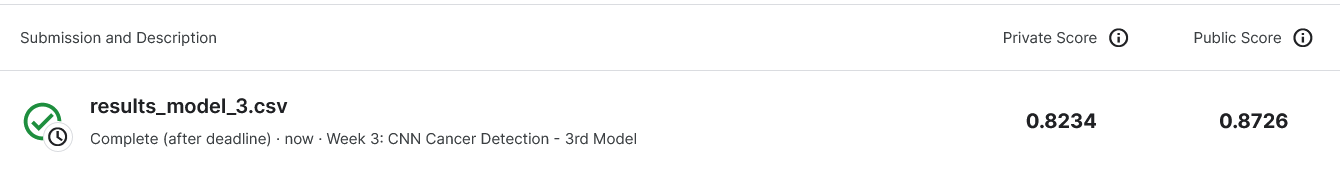

The optimized acheived a 7% increase in the testing score with just over a quarter of the original model's parameters. It is likely that further optimizations to the model's hyper-parameters, alongside minor improvement's to the general architecture, could achieve an even better score.

## Conclusions

### Learnings

The goal of classifying the Hispathologic sample images with a CNN was successfull, achieving a model with at least an Area Under the ROC Curve score of 0.90.

When comparing the multiple models we can conclude that in a Convolutional Neural Network the hyper-parameter optimization can have a much greater role for improvement than modifying the architecture itself. As seen above, the third model had a similar result to the second model with only 6% of the parameters. Not only did this result in a less computationaly expensive training, it also reduced the training itself to a third of the time.

### Future works

If there was more time to fine-tune the model, it would be worth examining more closely the effect of cropping the input to the model's accuracy. It would also be worth to dedicate more time to obtain the idel number of filters per Convolutional layer, or neurons per Dense layer.

## References

* [Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle.](https://kaggle.com/competitions/histopathologic-cancer-detection)